In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1

## a

In [21]:
mri = cv2.imread('MRI.jpg', cv2.IMREAD_GRAYSCALE)
mri2 = cv2.imread('MRI2.jpg', cv2.IMREAD_GRAYSCALE)
points = []

# Mouse callback function
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append([x, y])
        # This draws a circle where you clicked
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
        cv2.imshow('win', img)
        print(f"Point captured: ({x}, {y})")

# Source first, then Target
image_files = [mri2, mri]
all_points = []

for img in image_files:
    # Reset points list for the current image
    points = []
    cv2.namedWindow('win', cv2.WINDOW_NORMAL)
    cv2.imshow('win', img)
    
    # Link the mouse click to the window
    cv2.setMouseCallback('win', click_event)

    print(f"Click 3 corresponding points on {img}...")
    
    # Wait until 3 points are clicked
    while True:
        k = cv2.waitKey(1) & 0xFF
        if len(points) == 3:
            print(f"3 points selected for {img}. Press any key to continue...")
            cv2.waitKey(0) # Wait for a key press to confirm and move on
            break
        if k == 27: # Allow exiting with esc key
            break
            
    all_points.append(points)
    cv2.destroyAllWindows()

# Convert for Affine 
src_points = np.float32(all_points[0]) # From source
dst_points = np.float32(all_points[1]) # From target

# calculating the matrix automatically
affine_matrix = cv2.getAffineTransform(src_points, dst_points)
print("\nCalculated Affine Matrix:")
print(affine_matrix)

Click 3 corresponding points on [[ 9 10 10 ...  6  7  6]
 [ 4 12 18 ...  2  9  4]
 [13 19 11 ...  5 12  6]
 ...
 [10 11  6 ... 23 17  3]
 [17 11  8 ...  9 13 17]
 [12  7 10 ...  6  9 11]]...
Point captured: (42, 127)
Point captured: (159, 132)
Point captured: (168, 105)
3 points selected for [[ 9 10 10 ...  6  7  6]
 [ 4 12 18 ...  2  9  4]
 [13 19 11 ...  5 12  6]
 ...
 [10 11  6 ... 23 17  3]
 [17 11  8 ...  9 13 17]
 [12  7 10 ...  6  9 11]]. Press any key to continue...
Click 3 corresponding points on [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]...
Point captured: (157, 52)
Point captured: (187, 101)
Point captured: (201, 99)
3 points selected for [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]. Press any key to continue...

Calculated Affine Matrix:
[[  0.27465668  -0.42696629 199.68913858]
 [  0.40980025   0.21067416   8.03277154]]


## b

In [22]:
rows, cols = mri.shape
warped_img = cv2.warpAffine(mri2, affine_matrix, (cols, rows))

## c

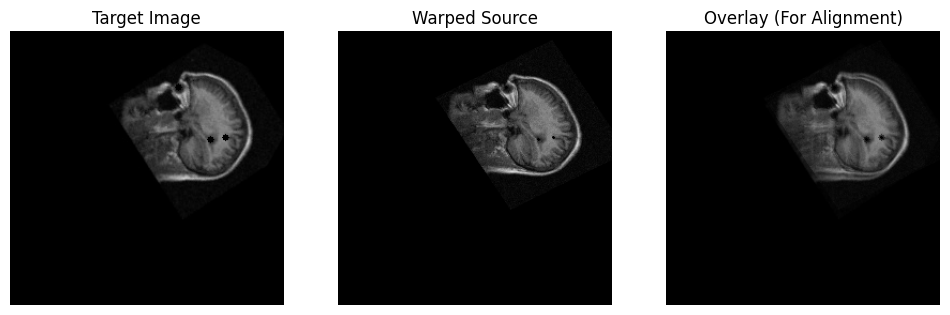

In [23]:
overlay = cv2.addWeighted(mri, 0.5, warped_img, 0.5, 0)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Target Image")
plt.imshow(cv2.cvtColor(mri, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Warped Source")
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay (For Alignment)")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Affine Transformation is a geometric operation that maps pixels from one coordinate system to another while preserving points, straight lines, and planes. The critical property of an affine transform is that *parallel lines remain parallel after the transformation*. This makes it ideal for correcting images there is translation, rotation, and scaling. 
- Mathematically, an affine transformation is defined by six parameters (or degrees of freedom) that control these movements. Because each point on a 2D image provides two values (an X and a Y coordinate), we need exactly three pairs of corresponding points to solve for these six unknowns. 

**Code:**

- In code, these three points form a triangle, and the algorithm calculates how to move, stretch, and rotate that triangle in the first image to perfectly match the triangle in the second image.
- First, cv2.getAffineTransform takes the two sets of coordinates and solves the linear system of equations to produce the 2×3 affine matrix. Then, cv2.warpAffine applies this matrix to the source image. The logic here is "inverse mapping": the function iterates over every pixel coordinate in the target destination, uses the inverse of the matrix to calculate where that pixel originated in the source image, and samples the intensity from that location.

**Point determination:**
Each single pair of corresponding points on the source image and its match on the target image provides two known values: one for the x coordinate and one for the y coordinate. This means that by every click, there'd be two equations to solve. Since we need six equations in total to solve for the six unknowns, and each point provides two equations, we need 3 points. If we provided only two points, we'd  have four equations for six unknowns, leaving the system "under-determined," meaning there would be infinite possible ways to warp the image that still satisfies your constraints. Moreover, if we had more than 3 points, the systems would be over-determined and thus, with no answer.

# 2

In [24]:
img = cv2.imread('shelf.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('shelf.jpg')
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE) 

## a, b, c altogether

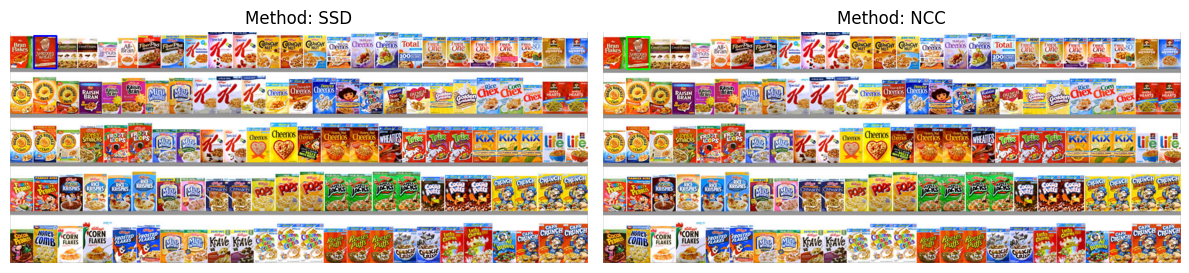

In [25]:
# dimensions for the final drawing
h, w = template.shape

# SSD
# Lower score(difference) = Better match.
res_ssd = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)

# location of the best match
# minMaxLoc returns 4 values: (min_value, max_value, min_location, max_location)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res_ssd)
top_left_ssd = min_loc
bottom_right_ssd = (top_left_ssd[0] + w, top_left_ssd[1] + h)

# Draw the rectangle on a copy of the image (Blue box for SSD)
img_ssd_result = img_color.copy()
cv2.rectangle(img_ssd_result, top_left_ssd, bottom_right_ssd, (255, 0, 0), 2)

# NCC, Higher score(correlation) = Better match.
res_ncc = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res_ncc)
top_left_ncc = max_loc
bottom_right_ncc = (top_left_ncc[0] + w, top_left_ncc[1] + h)

# Draw the rectangle on a copy of the image (Green box for NCC)
img_ncc_result = img_color.copy()
cv2.rectangle(img_ncc_result, top_left_ncc, bottom_right_ncc, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Method: SSD")
plt.imshow(cv2.cvtColor(img_ssd_result, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Method: NCC")
plt.imshow(cv2.cvtColor(img_ncc_result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

**SSD:**

The logic of SSD is based on calculating "difference" or error. As the template slides over the image, the algorithm subtracts the template pixel values from the image pixel values, squares the results (to eliminate negative numbers), and sums them up. In this logical framework, a perfect match results in a value of zero (because X−X=0). Therefore, the "best" match is the one with the lowest score. 

**NCC:**

It calculates a statistical correlation coefficient. Instead of measuring error, it measures "similarity." The resulting score is a value between -1 and +1, where +1 indicates a perfect positive correlation (the images are identical). Because we are looking for the highest similarity, the "best" match is the one with the highest score.

The primary reason NCC is superior is its resistance to lighting variations. SSD calculates the strict numerical difference between pixel values. If the template image is bright but the same object in the main image is in a shadow, SSD will calculate a massive "error" and fail to match them, even though the shape is identical. NCC, however, is a statistical calculation that normalizes the data. It looks at the relationship between pixels rather than their absolute brightness. Therefore, NCC can successfully find a template even if the main image is significantly darker, brighter, or has lower contrast than the original template.

# 3

## a

In [26]:
def intensity_based_registration(I_fixed, I_moving, initial_T, iterations=100, learning_rate=0.001):
    # flatten the 2x3 matrix into a 1D vector of 6 parameters [a, b, tx, c, d, ty]
    theta = initial_T.flatten().astype(np.float32)
    
    # dimensions for warping
    rows, cols = I_fixed.shape[:2]

    for i in range(iterations):
        # Reconstruct the 2x3 Affine Matrix 'T' from the current parameters 'theta'
        current_T = theta.reshape(2, 3)
        
        # 2-1: Warp and calculate error 
        I_warped = cv2.warpAffine(I_moving, current_T, (cols, rows)) # Apply the current transformation to the moving image
        
        # Calculate the difference: I_fixed(p) - I_moving(T(p))
        error_image = I_fixed.astype(np.float32) - I_warped.astype(np.float32)
        
        # 2-2: Gradient Calculation (Chain Rule)

        # Ix: Gradient in x-direction, Iy: Gradient in y-direction.
        Ix = cv2.Sobel(I_warped, cv2.CV_64F, 1, 0, ksize=5)
        Iy = cv2.Sobel(I_warped, cv2.CV_64F, 0, 1, ksize=5)

        # Jacobian Grid
        y_grid, x_grid = np.indices((rows, cols))

        Ix_flat = Ix.flatten()
        Iy_flat = Iy.flatten()
        x_flat = x_grid.flatten()
        y_flat = y_grid.flatten()
        error_flat = error_image.flatten()

        # The Steepest Descent Images (Gradient * Jacobian)
        # x_new = theta[0]*x + theta[1]*y + theta[2]
        # y_new = theta[3]*x + theta[4]*y + theta[5]
        
        # Derivatives for the X-transformation parameters (a, b, tx):
        J1 = Ix_flat * x_flat  # dE/da  (Scale/Shear X)
        J2 = Ix_flat * y_flat  # dE/db  (Shear/Rotate X)
        J3 = Ix_flat * 1       # dE/dtx (Translate X)
        
        # Derivatives for the Y-transformation parameters (c, d, ty):
        J4 = Iy_flat * x_flat  # dE/dc  (Shear/Rotate Y)
        J5 = Iy_flat * y_flat  # dE/dd  (Scale/Shear Y)
        J6 = Iy_flat * 1       # dE/dty (Translate Y)

        # Accumulate over all pixels: Sum( -2 * Error * Gradient_term)      
        grad_0 = np.sum(-2 * error_flat * J1)
        grad_1 = np.sum(-2 * error_flat * J2)
        grad_2 = np.sum(-2 * error_flat * J3)
        grad_3 = np.sum(-2 * error_flat * J4)
        grad_4 = np.sum(-2 * error_flat * J5)
        grad_5 = np.sum(-2 * error_flat * J6)

        # Combine into a single vector of 6 gradients
        gradient_vector = np.array([grad_0, grad_1, grad_2, grad_3, grad_4, grad_5])
        
        # 2-3: Update Parameters: theta_new = theta_old - (eta * gradient)
        theta = theta - (learning_rate * gradient_vector)

    T_optimized = theta.reshape(2, 3)
    
    return T_optimized

**Code:**

### 2-1

- We extract the dimensions of the fixed image (`rows` and `cols`) to ensure that all subsequent warping operations generate images that perfectly match the size of our target reference.

Inside the main loop, the code performs the forward process of the optimization. First, it reconstructs the  matrix from the current parameter vector and applies this transformation to the moving image. Then, the code calculates the `error_image` by subtracting the warped image from the fixed target image. This difference map represents the gradient of the energy function with respect to pixel intensity; high values indicate areas where the images do not yet align, driving the subsequent correction steps.

###  2-2: Gradient Calculation using Chain Rule

The gradient tells us how to adjust the parameters to reduce the error, which relies on the Chain Rule. First, `cv2.Sobel` is used to compute the spatial image gradients (`Ix` and `Iy`), which identify the edges and textures in the warped image. Second, the code generates coordinate grids (`x_grid`, `y_grid`) to serve as the Jacobian. The Jacobian defines how a change in the transformation parameters (like rotation or scale) translates to a physical movement of pixels at different locations.

The code then combines these components to compute the partial derivatives for each of the six parameters. For instance, `J1` represents the derivative for the first parameter (scaling/shearing in X); it is calculated by multiplying the image gradient in X (`Ix`) by the x-coordinate (`x_flat`). Finally, the code sums up the contributions from every pixel using the formula.

#### Calculation of error's gradient

The goal of this step is to calculate the Gradient of the Error (∇E), which acts as a directional guide telling the algorithm exactly how to adjust the transformation parameters to minimize the difference between the two images.

Image Gradient (∇I) acts as a spatial sensitivity map. It measures how quickly the pixel intensity changes as we move across the image (derivatives in the x and y directions). In other words, the Image Gradient tells the algorithm where movement matters. It ensures that the optimization focuses entirely on edges while ignoring flat, featureless areas where movement would be undetectable.

Jacobian acts as a geometric translator. It defines the mathematical relationship between the transformation parameters and the physical coordinates of the pixels.

Different parameters move pixels in different ways. A Translation parameter moves every pixel in the image by the exact same amount. A Rotation parameter, however, moves pixels differently depending on their location (a pixel in the center might barely move, while a pixel in the corner might relocate substantially). The Jacobian calculates this specific movement vector for every single pixel.

### 2-3: Parameter Update

The final step in the loop is the optimization update. The code updates the parameter vector theta by subtracting the calculated gradient multiplied by learning_rate. This step adjusts the transformation parameters slightly to reduce the alignment error. This entire process repeats for the specified number of iterations, gradually refining the parameters until the moving image aligns with the fixed image.

# 4

Optimal Threshold found: 66


C:\Users\MDastranj\AppData\Local\Temp\ipykernel_14216\1257412466.py:26: RuntimeWarning: invalid value encountered in scalar divide
  mu1 = np.sum(np.arange(k+1, 256) * norm_hist[k+1:]) / w1


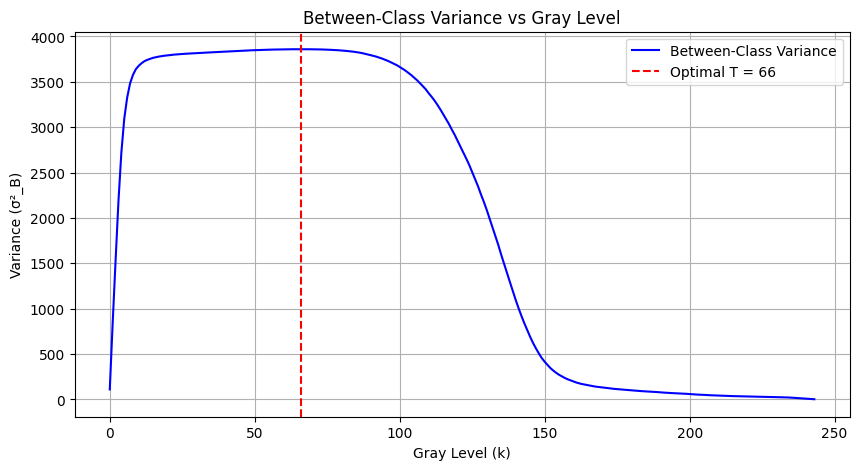

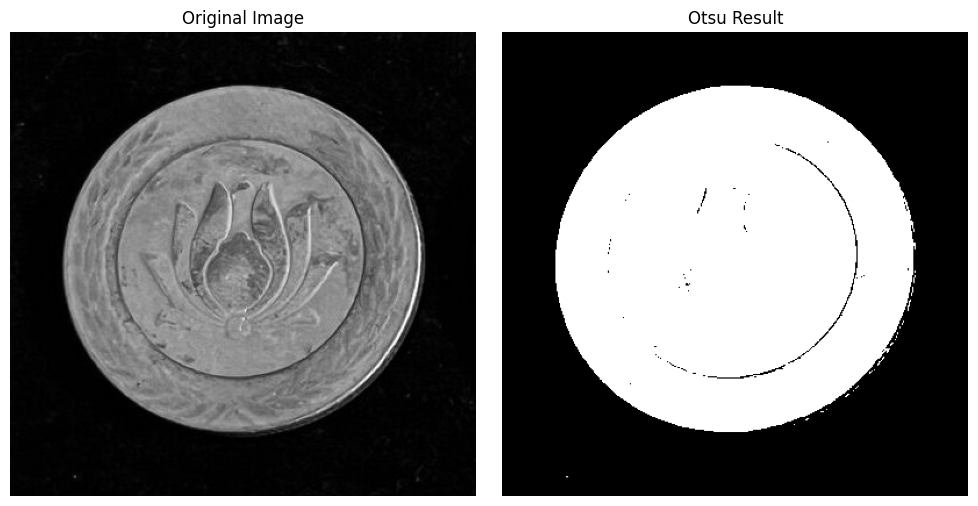

In [32]:
coin = cv2.imread('coin.png', cv2.IMREAD_GRAYSCALE)
def otsu(img):
    e = 1
    # Threshold
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    total_pixels = img.shape[0] * img.shape[1] # Normalize histogram to get probability density function (pdf)
    norm_hist = hist.ravel() / total_pixels

    # the best threshold results
    max_sigma_b = 0
    optimal_threshold = 0
    
    # Between-Class Variance
    between_class_variances = np.zeros(256)

    # Iterates through all possible thresholds (0 to 255)
    # I calculate probabilities (omega) and means (mu) for each split
    for k in range(256):
        # Class 0: Background (pixels with intensity <= k)
        # Class 1: Foreground (pixels with intensity > k)
        # Probabilities (Weights): w0 and w1
        w0 = np.sum(norm_hist[:k+1])
        w1 = np.sum(norm_hist[k+1:])

        mu0 = np.sum(np.arange(k+1) * norm_hist[:k+1]) / w0
        mu1 = np.sum(np.arange(k+1, 256) * norm_hist[k+1:]) / w1

        sigma_b = w0 * w1 * ((mu0 - mu1) ** 2)
        
        # Store for plotting
        between_class_variances[k] = sigma_b

        # Check if this is the max variance
        if sigma_b > max_sigma_b:
            max_sigma_b = sigma_b
            optimal_threshold = k

    print(f"Optimal Threshold found: {optimal_threshold}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(256), between_class_variances, color='blue', label='Between-Class Variance')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal T = {optimal_threshold}')
    plt.title('Between-Class Variance vs Gray Level')
    plt.xlabel('Gray Level (k)')
    plt.ylabel('Variance (\u03C3\u00B2_B)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # op = 150
    # Pixels > threshold become 255 (white), others 0 (black)
    final_img = img.copy()
    final_img[img > optimal_threshold] = 255
    final_img[img <= optimal_threshold] = 0

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(final_img, cmap='gray')
    plt.title(f'Otsu Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


otsu(coin)

We could apply closing to get a better result.

The code calculates the Histogram of the image. A histogram counts how many pixels exist for every gray level from 0 to 255.

    Normalization: The code divides the raw histogram counts by total_pixels. This converts the "counts" into "probabilities" (a Probability Density Function). This is a crucial step because the mathematical formulas for Otsu's method rely on probabilities (ω) rather than raw pixel counts.

2. The Optimization Loop (The Core Logic)

The heart of the code is the for k in range(256) loop. This is a brute-force search. The code assumes that every single gray level from 0 to 255 could potentially be the correct threshold. It tests them one by one.

Inside the loop, for every potential threshold k, the code splits the image pixels into two theoretical groups:

    Class 0 (Background): All pixels darker than or equal to k.

    Class 1 (Foreground): All pixels lighter than k.

For each split, it calculates three statistical values:

    Weights (ω0​,ω1​): The probability (or percentage) of pixels falling into each class.

    Means (μ0​,μ1​): The average intensity of pixels within each class.

    Between-Class Variance (σB2​): This is calculated using the formula: sigma_b = w0 * w1 * ((mu0 - mu1) ** 2)

The Logic of Variance: This formula measures how distinct the two classes are.

    If the means (μ0​ and μ1​) are far apart, the variance is high (Good separation).

    If the means are close together, the variance is low (Bad separation). The goal of Otsu’s method is to maximize this value.

3. Finding the Optimal Threshold

As the loop runs, the code keeps track of the highest variance found so far using if sigma_b > max_sigma_b.

    If the current k produces a better separation than any previous k, it updates optimal_threshold.

    By the end of the loop, optimal_threshold holds the exact gray level that mathematically separates the coin from the background most effectively.

4. Visualization and Application

Once the loop finishes:

    Graph Plot: The code uses matplotlib to draw a curve of the "Between-Class Variance." You will see this curve rise, peak, and fall. The red dashed line marks the peak, proving visually that the algorithm picked the point of maximum separation.

    Binarization: Finally, the code applies this found threshold.

        final_img[img > optimal_threshold] = 255: Any pixel brighter than the threshold becomes pure white.

        final_img[img <= optimal_threshold] = 0: Any pixel darker becomes pure black.

# 5

## b

## c

# 6